# Example Experiment
> Experiment using Repeated MNIST and BatchBALD vs BALD vs random sampling

This notebook ties everything together and runs an AL loop.

In [1]:
# experiment

import blackhc.project.script
from tqdm.auto import tqdm
WANDB_CONSOLE='off'
import os
os.environ['WANDB_CONSOLE'] = 'off'

Neither src found as subdirectory in %s nor was a notebooks directory found!
%load_ext autoreload
%autoreload 2


In [2]:
import time
import numpy as np
import random
import pandas as pd
import csv
import os.path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
import math
import torch
from torch.nn import functional as F
import torchvision

from batchbald_redux import (
    active_learning,
    batchbald,
    consistent_mc_dropout,
    joint_entropy,
    repeated_mnist,
    emnist,
    fashionmnist,
    cifar10,
    cifar100,
    svhn
)

from cnn_models import (
    CNN_MC_RMNIST,
    CNN_ENS_RMNIST,
    CNN_MC_EMNIST,
    CNN_ENS_EMNIST,
    CNN_ENS_CIFAR10
)

from utils import init_glorot, plot_graph

import warnings
warnings.filterwarnings('ignore')

In [4]:
from pytorch_resnet_cifar10.resnet import resnet20

In [5]:
dataset = 'CIFAR100'
uns_type = "ENS"
num_initial_samples = 1000

if dataset == 'CIFAR100':
    train_dataset, test_dataset = cifar100.create_CIFAR100_dataset()
    num_classes = 100
    initial_samples = active_learning.get_balanced_sample_indices(
    cifar100.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)
elif dataset == 'SVHN':
    train_dataset, test_dataset = svhn.create_SVHN_dataset()
    num_classes = 10
    initial_samples = active_learning.get_balanced_sample_indices(
    svhn.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

Files already downloaded and verified


In [6]:
algs = ['PLBB', 'PBALD', 'Rand', 'LBB', 'BALD']

random_seeds = [42] # choose 4 more

max_training_samples = 10000
acquisition_batch_size = 100
num_inference_samples = 100
num_test_inference_samples = 5
num_samples = 100000

test_batch_size = 512
batch_size = 64 # 64
scoring_batch_size = 128 # 128
training_iterations = 4096 * 6 # 4096 * 6 # 18

T = 10

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

config = {
    'max_training_samples': max_training_samples,
    'number of models': T,
    'train batch size': batch_size,
    'pool batch size': scoring_batch_size,
    'num_initial_samples': num_initial_samples,
    'train size': len(train_dataset),
    'test size': len(test_dataset),
    'pool size': len(train_dataset) - num_initial_samples
} 
PATH = 'results/' + uns_type + '/' + dataset + '/' + str(acquisition_batch_size)
try:
    os.makedirs(PATH)    
except FileExistsError:
    pass

with open(PATH + '/config.json', 'w') as f:
    json.dump(config, f)

for random_seed in random_seeds:
    for alg in algs:
#         for alpha in [1, 2, 3, 4, 5, 6, 7, 8]:
            random.seed(random_seed)
            np.random.seed(random_seed)
            torch.manual_seed(random_seed)
            torch.backends.cudnn.deterministic = True

            print("curr alg:", alg)
            use_cuda = torch.cuda.is_available()

            print(f"use_cuda: {use_cuda}")

            device = "cuda:1" if use_cuda else "cpu"

            kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

            active_learning_data = active_learning.ActiveLearningData(train_dataset)

            # Split off the initial samples first.
            active_learning_data.acquire(initial_samples)

            # THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
    #         active_learning_data.extract_dataset_from_pool(40000) 

            train_loader = torch.utils.data.DataLoader(
                active_learning_data.training_dataset,
                sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
                batch_size=batch_size,
                **kwargs,
            )

            pool_loader = torch.utils.data.DataLoader(
                active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
            )

            # Run experiment
            test_accs = []
            test_loss = []
            added_indices = []

            pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")

            while True:
                models = []
                for _ in range(T):
                    model = torchvision.models.resnet18(pretrained=False, num_classes=num_classes).to(device=device)
#                     model = resnet20().to(device=device)
                    model.apply(init_glorot)
                    optimizer = torch.optim.Adam(model.parameters())
#                     optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

                    model.train()

                    # Train
                    for data, target in tqdm(train_loader, desc="Training", leave=False):
                        data = data.to(device=device)
                        target = target.to(device=device)

                        optimizer.zero_grad()

                        prediction = torch.log_softmax(model(data), dim=1) #.squeeze(1) # was with 1 -- why?
                        loss = F.nll_loss(prediction, target)

                        loss.backward()
                        optimizer.step()

                    models.append(model)

                # Test
                for model in models:
                    model = model.eval()

                loss = 0
                correct = 0
                with torch.no_grad():
                    for data, target in tqdm(test_loader, desc="Testing", leave=False):
                        data = data.to(device=device)
                        target = target.to(device=device)

                        ens_test_output = []
                        for model in models:
                            ens_test_output.append(torch.log_softmax(model(data), dim=1))
                        ens_test_output = torch.stack(ens_test_output, dim=1)

                        prediction = torch.logsumexp(ens_test_output, dim=1) - math.log(T)
                        loss += F.nll_loss(prediction, target, reduction="sum")

                        prediction = prediction.max(1)[1]
                        correct += prediction.eq(target.view_as(prediction)).sum().item()

                loss /= len(test_loader.dataset)
                test_loss.append(loss)

                percentage_correct = 100.0 * correct / len(test_loader.dataset)
                test_accs.append(percentage_correct)

                print(
                    "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
                        loss, correct, len(test_loader.dataset), percentage_correct
                    )
                )

                filename = PATH + "/" + alg + str(random_seed) + ".csv"
#                 filename = PATH + "/" + alg + str(random_seed) + 'alpha' + str(alpha) + ".csv"
                file_exists = os.path.isfile(filename)

                with open(filename, 'a+', newline='') as csvfile:
                    fieldnames = ['Number of samples', 'Test accuracy', 'Test loss', 'Time']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

                    if not file_exists:
                        writer.writeheader()

                    if len(active_learning_data.training_dataset) != num_initial_samples: 
                        period = "{:.6f}".format(end - start)
                    else:
                        period = 0

                    writer.writerow({'Number of samples': len(active_learning_data.training_dataset),
                                     'Test accuracy': percentage_correct,
                                     'Test loss': "{:.6f}".format(loss.item()),
                                     'Time': period,
                    })
                    csvfile.close()

                if len(active_learning_data.training_dataset) >= max_training_samples:
                    break

                # Acquire pool predictions # = pred from selected pool
                N = len(active_learning_data.pool_dataset)
                logits_N_K_C = torch.empty((N, T, num_classes), dtype=torch.double, pin_memory=use_cuda)
            #     print("logits_N_K_C.size():", logits_N_K_C.size())

                with torch.no_grad():
                    model.eval()

                    for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
                        data = data.to(device=device)

                        lower = i * pool_loader.batch_size
                        upper = min(lower + pool_loader.batch_size, N)

                        ens_pool_output = []
                        for model in models:
                            ens_pool_output.append(torch.log_softmax(model(data), dim=1))
            #             print("len(ens_pool_output):", len(ens_pool_output))
                        ens_pool_output = torch.stack(ens_pool_output, axis=1)
            #             print("ens_pool_output.size():", ens_pool_output.size())

                        logits_N_K_C[lower:upper].copy_(ens_pool_output.double(), non_blocking=True)

                with torch.no_grad():
                    torch.cuda.synchronize()
                    start = time.perf_counter()
                    if alg == 'BB':
                        candidate_batch = batchbald.get_batchbald_batch(
                            logits_N_K_C, acquisition_batch_size, num_samples, dtype=torch.double, device=device
                        )
                    elif alg == 'LBB':
                        candidate_batch = batchbald.get_lbb_batch(
                            logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
                        )
                    elif alg == 'BALD':
                        candidate_batch = batchbald.get_bald_batch(
                            logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
                        )
                    elif alg == 'Rand':
                        candidate_batch = batchbald.get_random_batch(
                            logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
                        )
                    elif alg == 'PLBB': 
                        candidate_batch = batchbald.get_powerlbb_batch(
                            logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device, alpha=5
                        )
                    elif alg == 'PBALD': 
                        candidate_batch = batchbald.get_powerbald_batch(
                            logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
                        )
                    end = time.perf_counter()
                    print("acquisition time (sec.):", end - start)
                if dataset == 'CIFAR100':
                    targets = cifar100.get_targets(active_learning_data.pool_dataset)
                elif dataset == 'SVHN':
                    targets = svhn.get_targets(active_learning_data.pool_dataset)
                dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

                print("Dataset indices: ", dataset_indices)
                print("Scores: ", candidate_batch.scores)
                print("Labels: ", targets[candidate_batch.indices])

                active_learning_data.acquire(candidate_batch.indices)
                added_indices.append(dataset_indices)
                pbar.update(len(dataset_indices))

curr alg: PLBB
use_cuda: True


Training Set Size: 100%|##########| 20000/20000 [00:00<?, ?it/s]

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionError    : self._shutdown_workers()can only test a child process

  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py",

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py",

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>

Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __de

Training:   0%|          | 0/192 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f981d8a9ca0>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py",

Test set: Average loss: 3.5071, Accuracy: 1762/10000 (17.62%)


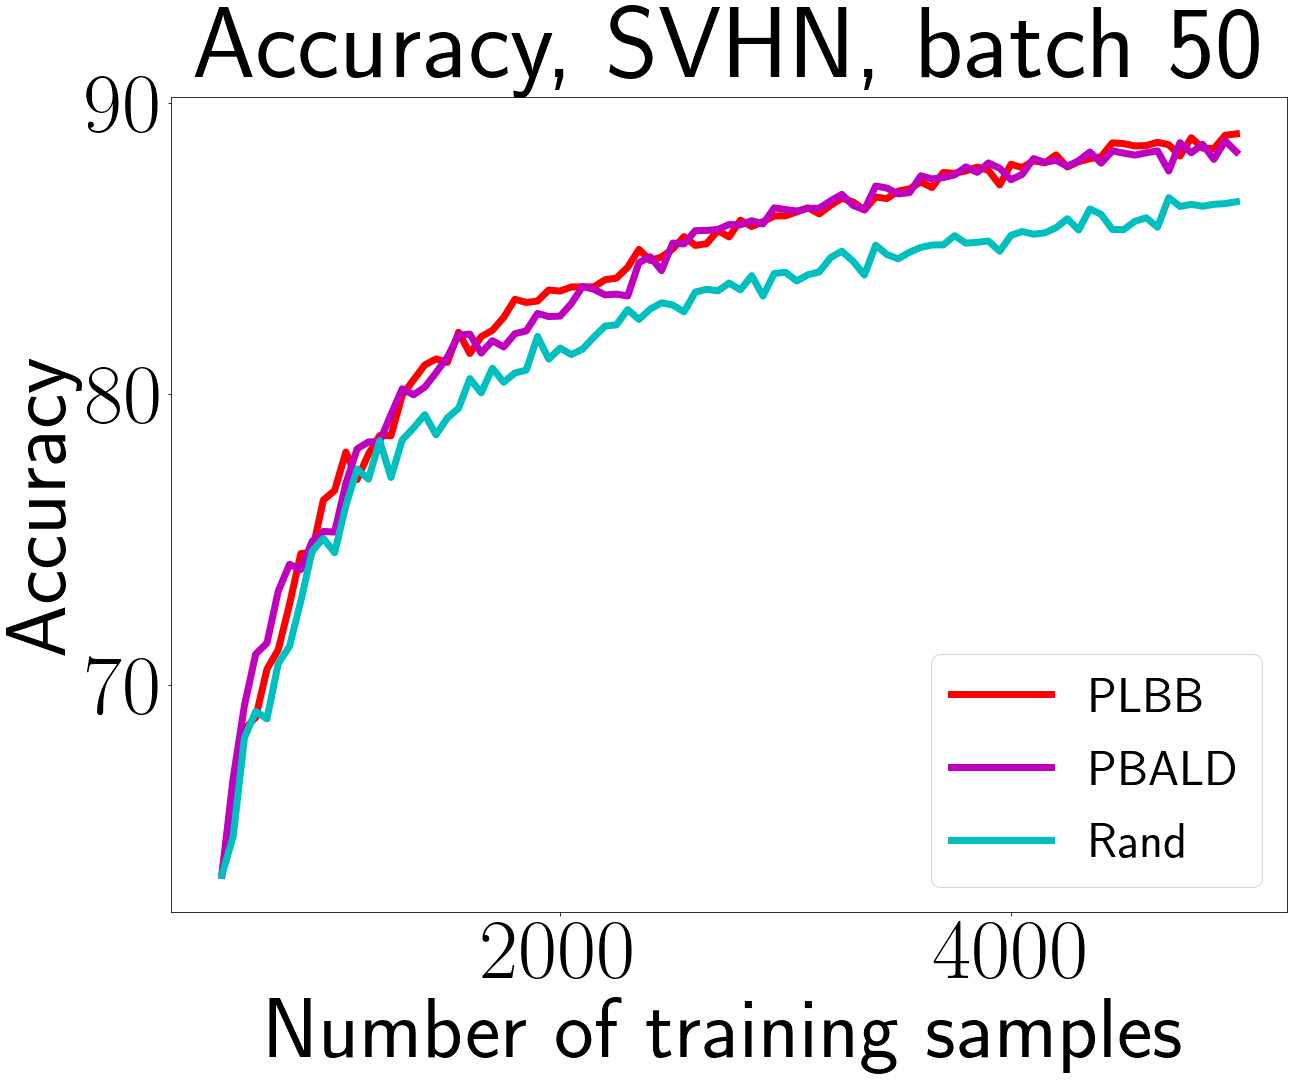

In [2]:
from utils import plot_graph
algs = ['PLBB', 'PBALD', 'Rand']
uns_type = 'ENS'
dataset_name = 'SVHN'
acquisition_batch_size = 50
random_seed = 42
num_initial_samples = 500
max_training_samples = 10000
PATH = 'results/' + uns_type + '/' + dataset_name + '/' + str(acquisition_batch_size) + '/'

plot_graph(PATH, algs, uns_type, dataset_name, acquisition_batch_size, random_seed, num_initial_samples, max_training_samples)

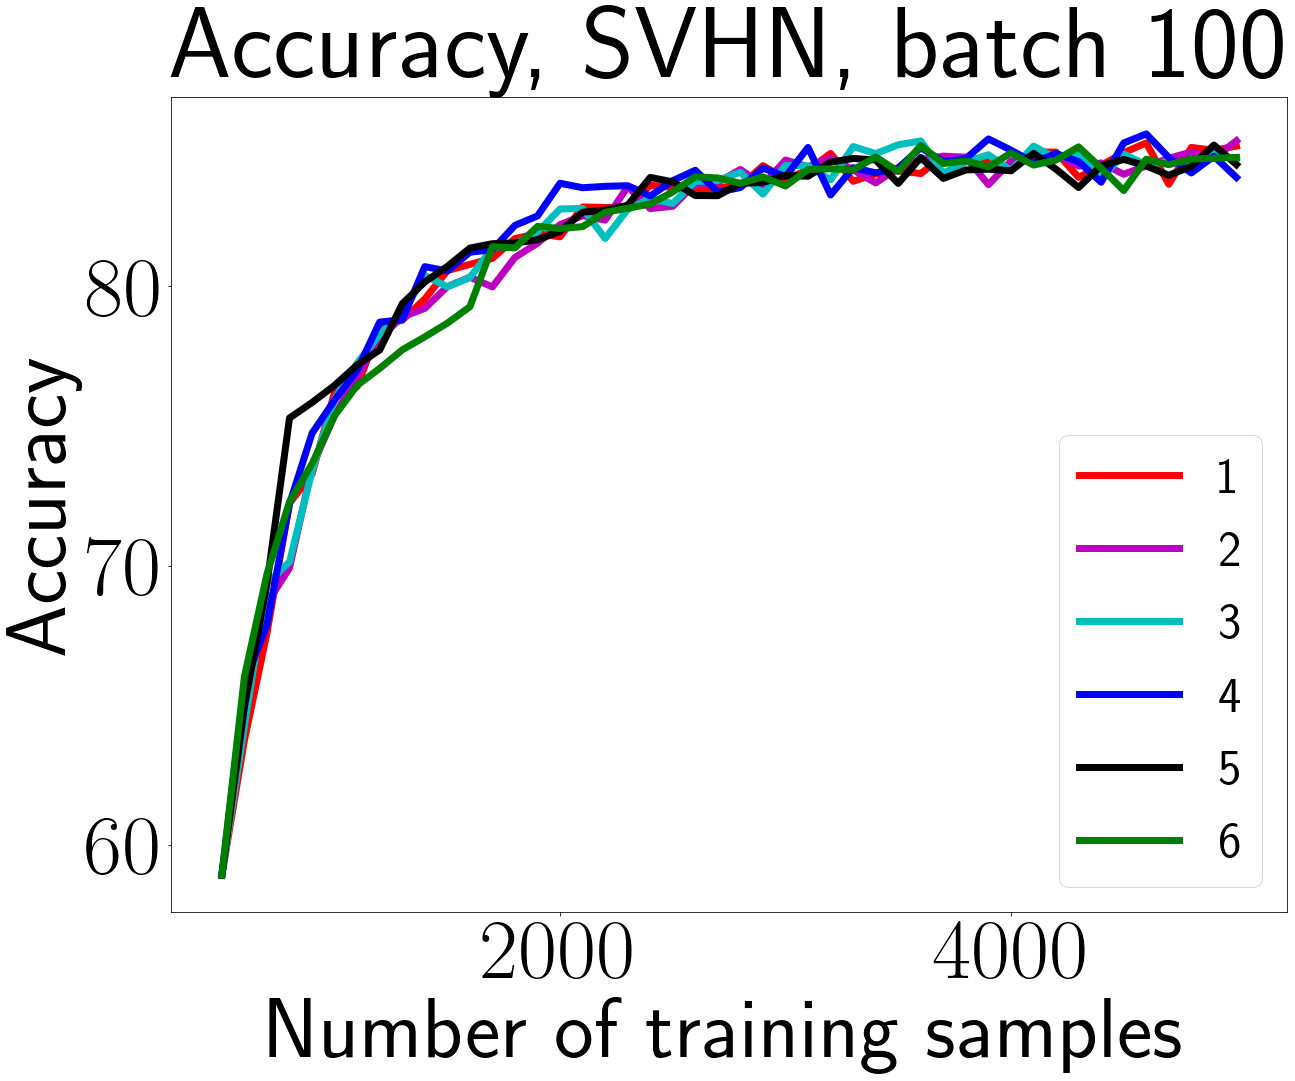

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

plt.figure(figsize=(20, 15))
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 85

uns_type = 'ENS'
dataset_name = 'SVHN'
acquisition_batch_size = 100
random_seed = 42
num_initial_samples = 500
max_training_samples = 5000
PATH = 'results/' + 'prev_' + uns_type + '/' + dataset_name + '/' + str(acquisition_batch_size) + '/'

alg_colors = {
    '1': 'r',
    '2': 'm',
    '3': 'c',
    '4': 'b', 
    '5': 'k',
    '6': 'g',
}

for alg in alg_colors:
    df = pd.read_csv('results/' + 'prev_' + uns_type + "/" + dataset_name + "/" + str(acquisition_batch_size) + "/" + 'PLBB' + str(random_seed)  + 'alpha' + alg + ".csv")
    plt.plot(np.arange(num_initial_samples, max_training_samples + acquisition_batch_size - 1, acquisition_batch_size), df['Test accuracy'], alg_colors[alg], label=alg, linewidth=7.0)

plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy, " + dataset_name + ", batch " + str(acquisition_batch_size))
plt.legend(fontsize=50)
plt.savefig(PATH + '/' + uns_type.lower() + '_' + dataset_name.lower() + '_batch' + str(acquisition_batch_size) + '.svg')